In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
print(tf.__version__)

2.4.0


# NumPy np.random.choice()

* [random.choice(a, size=None, replace=True, p=None)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

> * a:  1-D array-like or int
> If an ndarray, a random sample is generated from its elements. If an int, the random sample is generated as if a were np.arange(a)
> * size: int or tuple of ints, optional
> Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. Default is None, in > which case a single value is returned.
> * replace: boolean, optional
> Whether the sample is with or without replacement
> * p: 1-D array-like, optional
> The probabilities associated with each entry in a. If not given the sample assumes a uniform distribution over all entries in a.
```

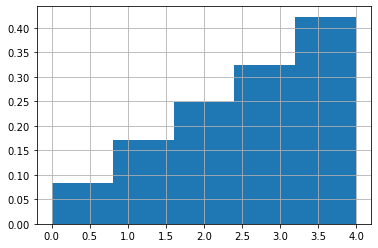

In [2]:
N = np.random.choice([0,1,2,3,4], 5000, p=[i/sum(range(1,6)) for i in range(1,6)])
plt.hist(N, density=True, bins=5)
plt.grid()

# Tensorflow tf.random.categorical()

* [tf.random.categorical](https://www.tensorflow.org/api_docs/python/tf/random/categorical)

```
tf.random.categorical(
    logits, num_samples, dtype=None, seed=None, name=None
)
```

> * logits: 			2-D Tensor with shape [batch_size, num_classes]. Each slice [i, :] represents the unnormalized log-probabilities for all classes.
> * num_samples: 		0-D. Number of independent samples to draw for each row slice.
> * dtype:			integer type to use for the output. Defaults to int64.
> * seed:			A Python integer. Used to create a random seed for the distribution. See tf.random.set_seed for behavior.


* [Can anyone give a tiny example to explain the params of tf.random.categorical?](https://stackoverflow.com/a/55065649/4281353)

> Each row of the `logits` tensor (`logits[0, :]`, `logits[1, :]`, ...) represents the event probabilities of a different [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution). The function does not expect actual probability values, but **unnormalized log-probabilities**. The actual probabilities would be `softmax(logits[0, :])`, `softmax(logits[1, :])`, etc. <br>  
> The benefit of this is that you can give any real values as input (e.g. the output of a neural network). It's trivial to use specific probability values or proportions, using logarithms. For example, both `[log(0.1), log(0.3), log(0.6)]` and `[log(1), log(3), log(6)]` represent the same probability, where the second class is three times as likely as the first one but only half as likely as the third one.<br>
>
> For each row of (unnormalized log-)probabilities, you get `num_samples` samples from the distribution. Each sample is an integer between `0` and `num_classes - 1`, drawn according to the given probabilities. The result is a 2D tensor with shape `[batch_size, num_samples]` with the sampled integers for each distribution.

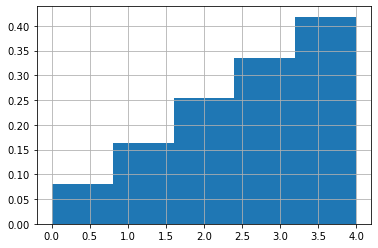

In [3]:
T = tf.random.categorical(tf.math.log([[i/sum(range(1,6)) for i in range(1,6)]]), 5000)
# T = tf.random.categorical([[i/sum(range(1,6)) for i in range(1,6)]], 1000)
plt.hist(T, density=True, bins=5)
plt.grid()

### Without probability distribution

In [138]:
def random_choice(a, size):
    """Random choice from 'a' based on size without duplicates
    Args:
        a: Tensor
        size: int or shape as tuple of ints e.g., (m, n, k).
    Returns: Tensor of the shape specified with 'size' arg.

    Examples:
        X = tf.constant([[1,2,3],[4,5,6]])
        random_choice(X, (2,1,2)).numpy()
        -----
        [
          [
            [5 4]
          ],
          [
            [1 2]
          ]
        ]
    """
    is_size_scalar: bool = \
        isinstance(size, int) or np.issubdtype(type(a), np.integer) or\
        (tf.is_tensor(a) and a.shape == () and a.dtype.is_integer)
    if is_size_scalar:
        shape = (size,)
    elif isinstance(size, tuple) and len(size) > 0:
        shape = size
    else:
        raise AssertionError(f"Unexpected size arg {size}")

    sample_size = tf.math.reduce_prod(size, axis=None)
    assert sample_size > 0

    # --------------------------------------------------------------------------------
    # Select elements from a flat array
    # --------------------------------------------------------------------------------
    a = tf.reshape(a, (-1))
    length = tf.size(a)
    assert sample_size <= length

    # --------------------------------------------------------------------------------
    # Shuffle a sequential numbers (0, ..., length-1) and take size.
    # To select 'sample_size' elements from a 1D array of shape (length,),
    # TF Indices needs to have the shape (sample_size,1) where each index
    # has shape (1,),
    # --------------------------------------------------------------------------------
    indices = tf.reshape(
        tensor=tf.random.shuffle(tf.range(0, length, dtype=tf.int32))[:sample_size],
        shape=(-1, 1)   # Convert to the shape:(sample_size,1)
    )
    return tf.reshape(tensor=tf.gather_nd(a, indices), shape=shape)


In [139]:
X = tf.constant([[1,2,3],[4,5,6]])
print(random_choice(X, (2,2,1)).numpy())

X = np.array([1,2,3,4,5,6])
print(random_choice(X, 2).numpy())

[[[6]
  [2]]

 [[4]
  [5]]]
[2 4]


---


# Tensor of K number of Tue values randomely set

In [78]:
def random_bool_tensor(shape: tuple, num: int):
    """Generate bool tensor where num elements are set to True
    Args:
        shape: shape of the tensor to generate
        num: number of 'True' elements in the result tensor
    Returns: tensor of shape where num elements are set to True
    """
    size = tf.math.reduce_prod(shape, axis=None)
    num = tf.cast(num, tf.int32)
    # Must check len(shape) as reduce_prod(([])) -> 1
    # https://stackoverflow.com/questions/67351236
    assert len(shape) > 0 <= num <= size

    # --------------------------------------------------------------------------------
    # TF Indices to update a 1D array of shape (size,).
    # Indices has the shape (size,1) where each index has shape (1,)
    # --------------------------------------------------------------------------------
    indices = tf.reshape(
        tensor=tf.random.shuffle(
            tf.range(0, size, dtype=tf.int32)
        )[:num],        # Shuffle a sequential indices and take 'num' indices
        shape=(-1,1)    # Convert to the shape:(size,1)
    )
    updates = tf.ones(shape=(num,),dtype=tf.int32)
    X = tf.tensor_scatter_nd_update(
        tensor=tf.zeros(shape=(size,), dtype=tf.int32),
        indices=indices,
        updates=updates
    )

    return tf.cast(tf.reshape(X, shape), dtype=tf.bool)


In [98]:
random_bool_tensor(shape=(3,2), num=5)

<tf.Tensor: shape=(3, 2), dtype=bool, numpy=
array([[ True,  True],
       [ True, False],
       [ True,  True]])>

In [53]:
shape=(2,3)
size = tf.math.reduce_prod(shape, axis=None)
size

<tf.Tensor: shape=(), dtype=int32, numpy=6>